In [5]:
# Library imports.
from pyswmm import Simulation, Links, Output
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute, SubcatchAttribute
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import numpy.random as nprnd
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
import time

# Local imports.
from urbansurge import swmm_model, analysis_tools, file_utils

In [ ]:
# Load in fault table
fault_table_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output\Noiseless\diameter_17_ramp_3in_n20_60min.csv"
fault_table = pd.read_csv(fault_table_fp)

In [61]:
# Datetime
t = fault_table.loc[fault_table['fault_value'] == 0, 'datetime']

# Fault values
fault_values = np.unique(fault_table['fault_value'])

# Precipitation
P = fault_table.loc[fault_table['fault_value'] == 0, 'prcp']

# Find peak precip values
Ppeak_i, _ = find_peaks(P)
Ppeak = P[Ppeak_i]

# Peak indices
peak_log = np.isin(P, Ppeak).astype(int)
peak_idx_diff = np.diff(peak_log)
peak_idx = np.where(peak_idx_diff == 1)[0]
peak_idx = np.append(peak_idx, len(P) - 1)


In [79]:
# Total node flooding for each peak
node_id = 38
node_flood_col_mask = fault_table.columns.str.startswith("Flood_node_" + str(node_id))

node_flooding = np.zeros((len(fault_values), len(peak_idx) - 1))
for i, fault_value in enumerate(fault_values):
    # Extract node flooding column(s).
    node_flood = fault_table[fault_table['fault_value'] == fault_value].loc[:, node_flood_col_mask].values
    
    # Loop through peaks and compute cumulative flooding.
    for j in range(len(peak_idx) - 1):
        peak_start_idx = peak_idx[j]
        peak_end_idx = peak_idx[j + 1]
        
        # Node flooding for a given peak.
        node_peak_flood = node_flood[peak_start_idx:peak_end_idx, :]
        if node_peak_flood.shape[1] > 1:
            cumu_node_flood = np.sum(np.trapz(node_peak_flood, axis=0) * 5 * 60, axis=1)
        else:
            cumu_node_flood = np.trapz(node_peak_flood, axis=0) * 5 * 60

        node_flooding[i, j] = cumu_node_flood

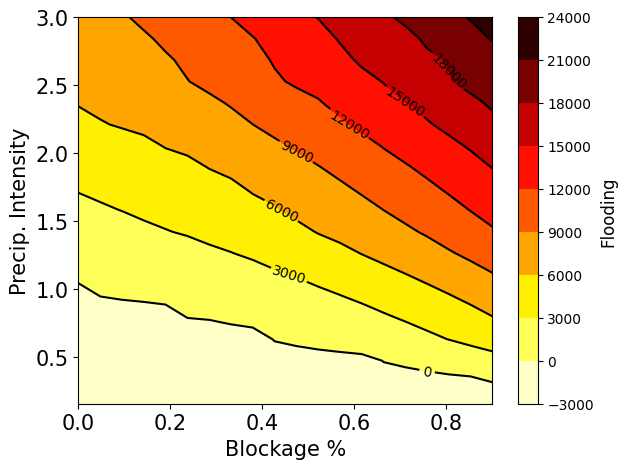

In [99]:
# Node flooding contour plot
node_flooding_contour = np.copy(node_flooding)
node_flooding_contour[node_flooding_contour <= 0] = -500

# Fault values as a percentage of maximum fault.
plot_fault_values = fault_values / 1

fig, ax = plt.subplots()

contourf = ax.contourf(plot_fault_values, Ppeak, node_flooding_contour.T, cmap='hot_r')
contour = ax.contour(plot_fault_values, Ppeak, node_flooding_contour.T, colors='black')  # Set color to black
ax.clabel(contour, inline=True, fontsize=10)
cbar = fig.colorbar(contourf, ax=ax, label='Flooding')
cbar.set_label('Flooding', fontsize=12)
ax.set_xlabel('Blockage %', fontsize=15)
ax.set_ylabel('Precip. Intensity', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.show()
fig.savefig(r"C:\Users\ay434\Box\Research\Smart_Stormwater\Manuscript\Figures\blockage_prcp_flood.png", dpi=300)